<h2>1. Contexte<h2/>

<h2>This notebook is dedicated to understanding the subject and exploring the data.<h2/>

<h3>"The dataset includes 174 metrics and 297,099 rows of data of tropical storms in the United States
collected from 1980 onwards. The data is raw, imperfect, and has not been cleaned or preprocessed."<h3/>

<h3>"Information about the dataset attributes can be found in the IBTRACS_variable_documentation file. Using the provided dataset, you are asked to train a model to predict the severity of a tropical cyclone based on geographical input data."<h3/>

We want to predict the 145th column of the dataset

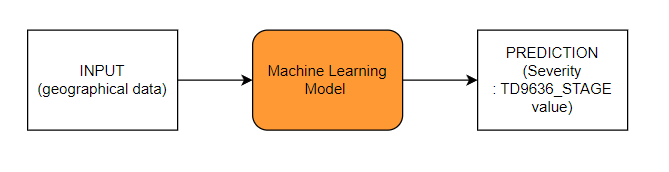

<h2>2. Data Exploration<h2/>

In [1]:
#Import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import plotly.express as px
import seaborn as sns

We noticed that the first row, that gives units of certain columns needed to be removed, as it would have been an issue in our dataset. 

In [2]:
#Import and read the csv file, forcing the NaN values in case of formating issues. Display the 5 first rows

df = pd.read_csv("ibtracs.csv",low_memory=False, na_values=["", " ", "-", "NA", "N/A"],dtype=str,skiprows=[1]) # to correct the formating issue when importing the csv
df.head(5)

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,350
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,350
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,360
3,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 09:00:00,TS,-11.7,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,10
4,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 12:00:00,TS,-11.5,172.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,20


In [3]:
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])  # Convert to int ou float if possible
    except ValueError:
        pass  # Ignore errors

print(df.dtypes)

SID               object
SEASON             int64
NUMBER             int64
BASIN             object
SUBBASIN          object
                  ...   
USA_SEARAD_SE    float64
USA_SEARAD_SW    float64
USA_SEARAD_NW    float64
STORM_SPEED      float64
STORM_DIR        float64
Length: 174, dtype: object


In [4]:
#We highlight the columns with NaN values, that will be an issue
df.isna().sum()

SID                   0
SEASON                0
NUMBER                0
BASIN             40518
SUBBASIN          32646
                  ...  
USA_SEARAD_SE    282038
USA_SEARAD_SW    283730
USA_SEARAD_NW    282124
STORM_SPEED           8
STORM_DIR             8
Length: 174, dtype: int64

In [5]:
# We count the number of NaN per columns to estimate the percentage of the df it represents
missing_values=df.isna().sum()

# disable the display limit
pd.set_option("display.max_rows", None)

total_rows = len(df)
missing_percentage = (missing_values / total_rows) * 100

print(missing_percentage.sort_values(ascending=False).to_frame(name="Missing Values Percentage"))

# reinitialize the configuration
pd.reset_option("display.max_rows")

                  Missing Values Percentage
MLC_LAT                          100.000000
TD9635_ROCI                      100.000000
REUNION_GUST                     100.000000
MLC_CLASS                        100.000000
MLC_WIND                         100.000000
MLC_PRES                         100.000000
TD9636_PRES                      100.000000
TD9635_LAT                       100.000000
TD9635_LON                       100.000000
TD9635_WIND                      100.000000
REUNION_R64_NW                   100.000000
REUNION_R64_NE                   100.000000
REUNION_R64_SW                   100.000000
REUNION_R64_SE                   100.000000
MLC_LON                          100.000000
TD9635_PRES                      100.000000
BOM_R64_NW                        99.806125
BOM_R64_SW                        99.800403
BOM_R64_SE                        99.795354
BOM_R64_NE                        99.792324
USA_RECORD                        99.754963
DS824_PRES                      

In [6]:
# Création d'un DataFrame pour Plotly
missing_df = pd.DataFrame({
    "Column Index": range(len(missing_values)),
    "Column": missing_values.index,  
    "Missing Percentage": missing_percentage.values  
})

# bar chart with plotly
fig = px.bar(
    missing_df,
    x="Column Index",
    y="Missing Percentage",
    text="Column",  #info-bulle
    title="Percentage of missing values per column"
)
fig.show()

#### Now, we have a first look at the columns and especially a more detailed vue of the ones with the most of missing values and the one without missing values. As we see by that and by looking directly at the csv file,a lot of columns have a high percentage of missing values:  **151/174 columns have more than 50% of missing values, and 16/174 columns have no values at all**

#### **We first decide to delete the columns that don't contain values, since they don't add anything.**

In [7]:
raw_df=df.copy()

In [8]:
empty_columns=missing_percentage[missing_percentage==100]
df.drop(columns=empty_columns.index,inplace=True)
df.shape

(297098, 158)

#### Another important point to notice is that the target metric itself, `TD9636_STAGE` has **83,7% of missing values**, so we need to further our investigation.
### And it means that there are **48343 rows** with available value of TD9636_STAGE, which is still a considerate amount of data.

In [9]:
df["TD9636_STAGE"].value_counts()

TD9636_STAGE
2.0    17204
1.0    16028
4.0    10623
0.0     3156
3.0      742
5.0      331
6.0      259
Name: count, dtype: int64

In [10]:
df.loc[df.TD9636_STAGE.notna(),:]

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST,BOM_GUST_PER,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,350.0
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,350.0
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,360.0
3,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 09:00:00,TS,-11.7,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,10.0
4,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 12:00:00,TS,-11.5,172.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67405,1989354N05155,1989,129,WP,MM,JACK,1989-12-29 00:00:00,TS,14.6,141.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,250.0
67406,1989354N05155,1989,129,WP,MM,JACK,1989-12-29 03:00:00,TS,14.4,141.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,250.0
67407,1989354N05155,1989,129,WP,MM,JACK,1989-12-29 06:00:00,TS,14.3,140.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,250.0
67408,1989354N05155,1989,129,WP,MM,JACK,1989-12-29 09:00:00,TS,14.1,140.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,250.0


### **Handling of `TD9636_STAGE`**
83.7% of missing value is too important, we can't fill those.
#### **We keep only the rows where `TD9636_STAGE` is not missing**  
#### 📌 Advantages:  
- Ensures the model is trained only with complete data.  
- No need to handle missing target values.  
- Easier.  


In [11]:
df = df.dropna(subset=['TD9636_STAGE'])
df.shape

(48343, 158)

Now we can continue cleaning our data, because we still have a lot of columns with missing values that we can considere unusable.
By looking through the list og missing percentage, we notice that we have a significant gap of percentages under 43% of missing value.
So we chose to fix a threshold around 40%. If a column has more than 40% of missing values, we chose to remove it.

In [12]:
threshold=40
#we recalculate the percentages
missing_values=df.isna().sum()
total_rows = len(df)
missing_percentage = (missing_values/ total_rows) * 100

#we remove columns with too many missing values
cols_to_drop=[col for col in df.columns if missing_percentage[col] > threshold]
df= df.drop(columns=cols_to_drop)
df.shape

(48343, 25)

In [13]:
df.columns

Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON', 'TRACK_TYPE', 'DIST2LAND', 'LANDFALL', 'IFLAG',
       'USA_ATCF_ID', 'USA_LAT', 'USA_LON', 'USA_WIND', 'USA_SSHS',
       'TD9636_LAT', 'TD9636_LON', 'TD9636_STAGE', 'TD9636_WIND',
       'STORM_SPEED', 'STORM_DIR'],
      dtype='object')

Among the remaining columns, we examined their relevance through their description in the ibtracs documentation. 
Hence,we decided to remove these columns that have useless information:
`SID`, `NAME`, `IFLAG`,`TRACK_TYPE`, `NUMBER`

In [14]:
df= df.drop(columns=["SID","NAME","NUMBER","IFLAG","TRACK_TYPE"])
df.shape

(48343, 20)

Moreover with the Ibtracs technical details we have information on some categories that are in fact equivalent to missing values. So we transform those to make it clear that it stands for NaN.

In [15]:
#before replacement
df["NATURE"].value_counts()

NATURE
TS    42660
MX     3077
DS     2305
ET      171
NR      130
Name: count, dtype: int64

In [16]:
df["BASIN"] = df["BASIN"].replace("MM", np.nan)
df["SUBBASIN"] = df["SUBBASIN"].replace("MM", np.nan)
df["NATURE"] = df["NATURE"].replace("NR", np.nan)
df["USA_SSHS"] = df["USA_SSHS"].replace(-5, np.nan)

In [17]:
#after replacement
print(df["NATURE"].value_counts())
print(df["NATURE"].isna().sum())

NATURE
TS    42660
MX     3077
DS     2305
ET      171
Name: count, dtype: int64
130


In [18]:
#we recalculate the percentages
missing_values=df.isna().sum()
total_rows = len(df)
missing_percentage = (missing_values / total_rows) * 100

print(missing_percentage.sort_values(ascending=False).to_frame(name="Missing Values Percentage"))


              Missing Values Percentage
SUBBASIN                      79.850237
TD9636_WIND                   17.886767
USA_WIND                      16.291914
USA_SSHS                      16.287777
USA_LON                       14.651552
USA_LAT                       14.651552
USA_ATCF_ID                   13.760007
TD9636_LAT                     2.155431
TD9636_LON                     2.155431
LANDFALL                       0.930848
NATURE                         0.268912
STORM_DIR                      0.002069
STORM_SPEED                    0.002069
ISO_TIME                       0.000000
SEASON                         0.000000
BASIN                          0.000000
LON                            0.000000
LAT                            0.000000
DIST2LAND                      0.000000
TD9636_STAGE                   0.000000


In [19]:
# Now we see that "SUBBASIN" has in fact many missing values, we remove this feature
df = df.drop(columns=["SUBBASIN"])
df.shape

(48343, 19)

We look for any columns with a null variance, that is to say, with one unique value.If this is the case, we canremove it since it doesn't add information

In [20]:
unique_counts = df.nunique()
unique_counts

SEASON             10
BASIN               5
ISO_TIME        24417
NATURE              4
LAT               862
LON              2605
DIST2LAND        3034
LANDFALL         3012
USA_ATCF_ID       772
USA_LAT           804
USA_LON          2356
USA_WIND          112
USA_SSHS            9
TD9636_LAT        836
TD9636_LON       2374
TD9636_STAGE        7
TD9636_WIND       140
STORM_SPEED        66
STORM_DIR          73
dtype: int64

Now we are going to look for correlations(between features, and with the target) to continue our data cleaning.

In [21]:
# to work on correlations, we start by identifying categorical columns
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()
print("numerical: ",num_cols)
print("categorical: ",cat_cols)

numerical:  ['SEASON', 'LAT', 'LON', 'DIST2LAND', 'LANDFALL', 'USA_LAT', 'USA_LON', 'USA_WIND', 'USA_SSHS', 'TD9636_LAT', 'TD9636_LON', 'TD9636_STAGE', 'TD9636_WIND', 'STORM_SPEED', 'STORM_DIR']
categorical:  ['BASIN', 'ISO_TIME', 'NATURE', 'USA_ATCF_ID']


In [22]:
df_le=df.copy()

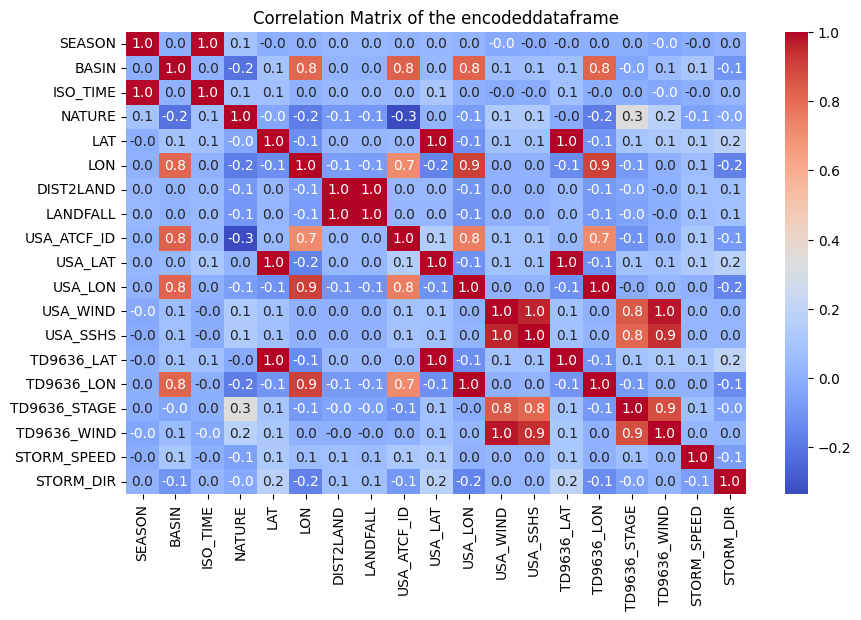

In [23]:
from sklearn.preprocessing import LabelEncoder

#we use label encoding here since it's just to analyse the correlations
for col in cat_cols:
    le = LabelEncoder()
    df_le[col] = le.fit_transform(df_le[col])
correlation_matrix = df_le.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Correlation Matrix of the encodeddataframe")
plt.show()

In [24]:
print(df_le["NATURE"].value_counts())

NATURE
3    42660
2     3077
0     2305
1      171
4      130
Name: count, dtype: int64


In [25]:
#the Label encoding has transformed the NaNs in 4, we change it to not forget that this feature is still with missing values
df_le["NATURE"] = df_le["NATURE"].replace(4, np.nan)

In [26]:
#First we analyze the columns with missing values that we can remove
missing_values=df_le.isna().sum()
columns_with_missing = missing_values[missing_values > 0]
columns_with_missing

NATURE          130
LANDFALL        450
USA_LAT        7083
USA_LON        7083
USA_WIND       7876
USA_SSHS       7874
TD9636_LAT     1042
TD9636_LON     1042
TD9636_WIND    8647
STORM_SPEED       1
STORM_DIR         1
dtype: int64

Among those, if two features are too correlated (here 1 or 0.98), we keep only one, refering the documentation to keep the more relevant.
- Between `USA_LAT` and `TD9636_LAT` we keep `TD9636_LAT` (fewer missing values)
- Between `USA_LON` and `TD9636_LON` we keep `TD9636_LON` (fewer missing values)
- Between `USA_WIND`( with fewer missing values) and `TD9636_WIND`(that is an estimation) we keep `USA_WIND`
- Between `USA_WIND` and `USA_SSHS` (100% correlated since sshs is derived from wind), We keep `USA_WIND` (more information and flexibility, and almost the same amount of nan)

We also choose to remove `USA_ATCF_ID` that has a high correlation with 2 other features and that by looking att the documentation is an ID with not very significant information .

In [27]:
df_le= df_le.drop(columns=["TD9636_WIND", "USA_LON","USA_LAT","USA_ATCF_ID","USA_SSHS"])
df_le.shape

(48343, 14)

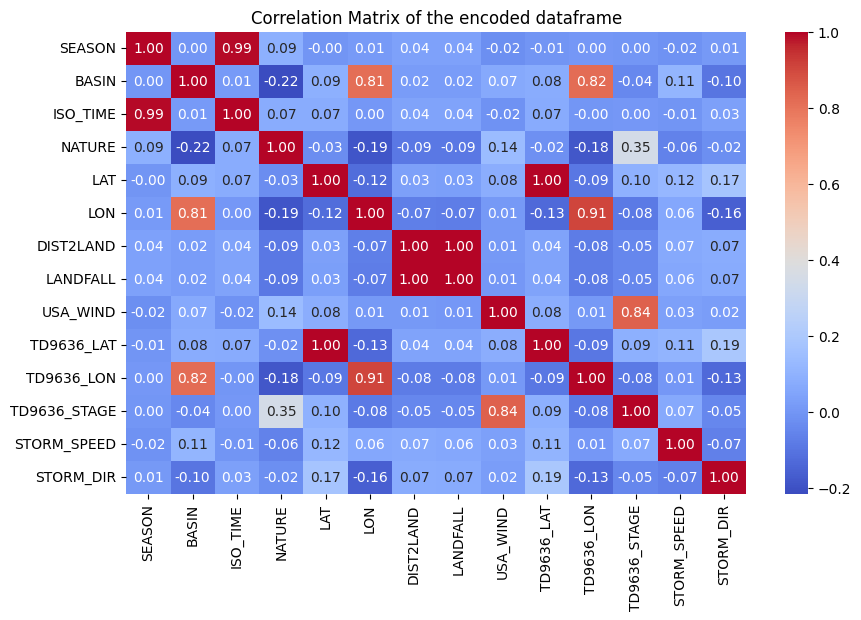

In [28]:
#we plot again

correlation_matrix = df_le.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of the encoded dataframe")
plt.show()

As above, we can delete one column when there is high correlation.  
- Between `ISO_TIME` and `SEASON` we keep `SEASON` (simplier)
- Between `LANDFALL` and `DIST2LAND` we keep `DIST2LAND` (no missing values)  
- Between `TD9636_LAT` and `LAT` we keep `LAT` (no missing values)
- Between `TD9636_LON` and `LON` we keep `LON` (no missing values)
- `USA_WIND` represents the maximum sustained wind speed from various US agencies across multiple ocean basins, and its strong 0.84 correlation with `TD9636_STAGE` is logical since both reflect cyclone intensity; however, it does not appear redundant, so we keep it.

In [29]:
df_le= df_le.drop(columns=["ISO_TIME", "LANDFALL","TD9636_LAT", "TD9636_LON"])
df_le.shape

(48343, 10)

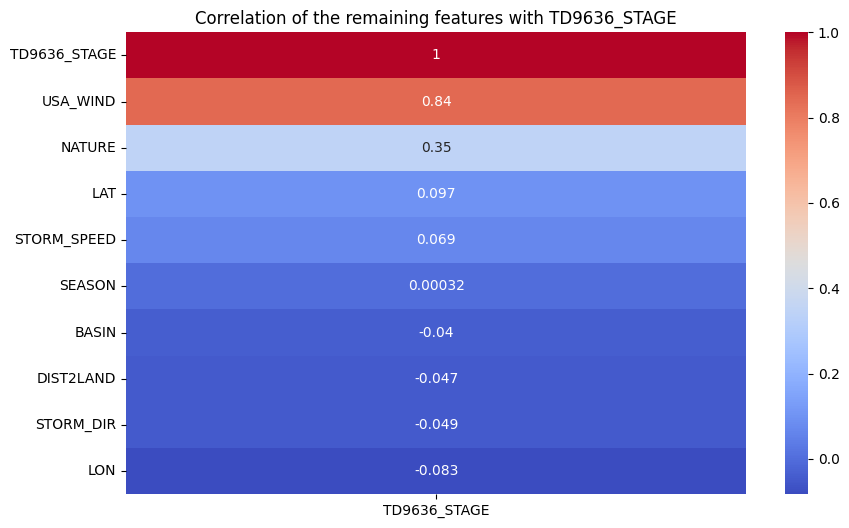

In [30]:
correlation_matrix = df_le.corr()
corr_td9636=correlation_matrix[["TD9636_STAGE"]].sort_values(by='TD9636_STAGE',ascending=False)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_td9636, annot=True,cmap='coolwarm')
plt.title("Correlation of the remaining features with TD9636_STAGE")
plt.show()

In [31]:
#missing values 
missing_values=df_le.isna().sum()
missing_values[missing_values>0]

NATURE          130
USA_WIND       7876
STORM_SPEED       1
STORM_DIR         1
dtype: int64

In [32]:
# we delete the rows with missing values for STORM speed and dir
#it appears to be the same row, 22705
df_le.loc[df_le["STORM_SPEED"].isna()]

,SEASON,BASIN,NATURE,LAT,LON,DIST2LAND,USA_WIND,TD9636_STAGE,STORM_SPEED,STORM_DIR
22705,1983,4,0.0,14.5,141.5,1747,NaN,0.0,NaN,NaN


In [33]:
df_le.drop(index=22705,inplace=True)
missing_values=df_le.isna().sum()
missing_values[missing_values>0]

NATURE       130
USA_WIND    7875
dtype: int64

In [34]:
# and the same for NATURE ( with 130 missing values so around 0.26% missing values)
df_le = df_le.drop(index=df_le.loc[df_le.NATURE.isna(),:].index)

In [35]:
missing_values=df_le.isna().sum()
missing_values

SEASON             0
BASIN              0
NATURE             0
LAT                0
LON                0
DIST2LAND          0
USA_WIND        7771
TD9636_STAGE       0
STORM_SPEED        0
STORM_DIR          0
dtype: int64

In [36]:
df_le.shape

(48212, 10)

We are now left with a dataframe of shape 48212rowsx10columns.
And with 1 column with missing values, USA_WIND with 7771 missing values,(so around 16%) we are going to fill. 

### Our action plan from now:
1. We start from our initial dataframe, keeping the 10 selected columns
2. We fill in the USA_WIND NaNs (feature engineering)
3. Check distribution and impact of transformations
4. We encode the BASIN and NATURE columns with OneHotEncoding with DropFirst (basin has only 5 categories and nature 4 categories, which is still reasonable for one hot encoding) to avoid creating a false hierarchy.


In [37]:
#1. datframe non encoded
remaining_cols=df_le.columns
remaining_rows=df_le.index
df = raw_df.loc[remaining_rows, remaining_cols]
df.shape

(48212, 10)

In [38]:
#2.Filling NaNs with the mean or median using other features
df.USA_WIND.describe()

count    40441.000000
mean        50.010658
std         25.487201
min         10.000000
25%         30.000000
50%         43.000000
75%         65.000000
max        155.000000
Name: USA_WIND, dtype: float64

In [39]:
df.isna().sum()

SEASON             0
BASIN              0
NATURE             0
LAT                0
LON                0
DIST2LAND          0
USA_WIND        7771
TD9636_STAGE       0
STORM_SPEED        0
STORM_DIR          0
dtype: int64

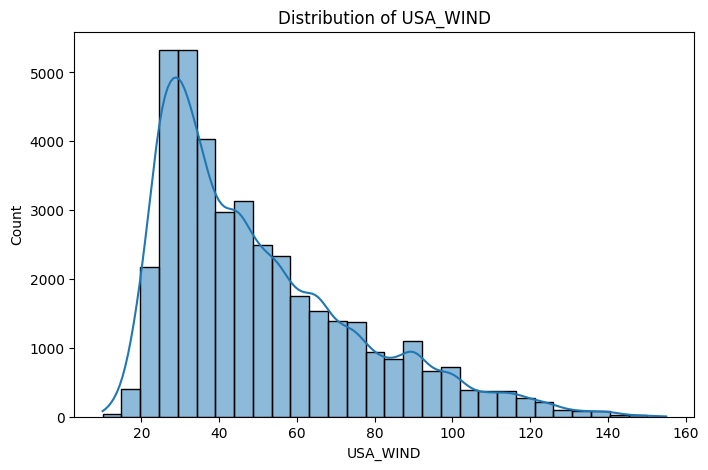

mean: 50.010657501050915 median: 43.0 variance: 25.487201461589425


In [40]:
#we start with looking at the distribution to choose between mean or median
plt.figure(figsize=(8, 5))
sns.histplot(df['USA_WIND'].dropna(), bins=30, kde=True)
plt.title("Distribution of USA_WIND")
plt.show()

print("mean:",df.USA_WIND.mean(),"median:", df.USA_WIND.median(),"variance:", df.USA_WIND.std())

The distribution is asymetrical (skewed right),so the median is the more reliable option to impute our USA_WIND column

In [41]:
df.groupby(["BASIN","NATURE"]).median().USA_WIND

BASIN  NATURE
EP     DS        20.0
       ET         NaN
       MX        17.5
       TS        40.0
NI     DS        30.0
       MX        30.0
       TS        35.0
SI     DS         NaN
       ET         NaN
       MX        40.0
       TS        43.0
SP     MX        25.0
       TS        43.0
WP     DS        20.0
       ET        41.5
       MX        25.0
       TS        48.0
Name: USA_WIND, dtype: float64

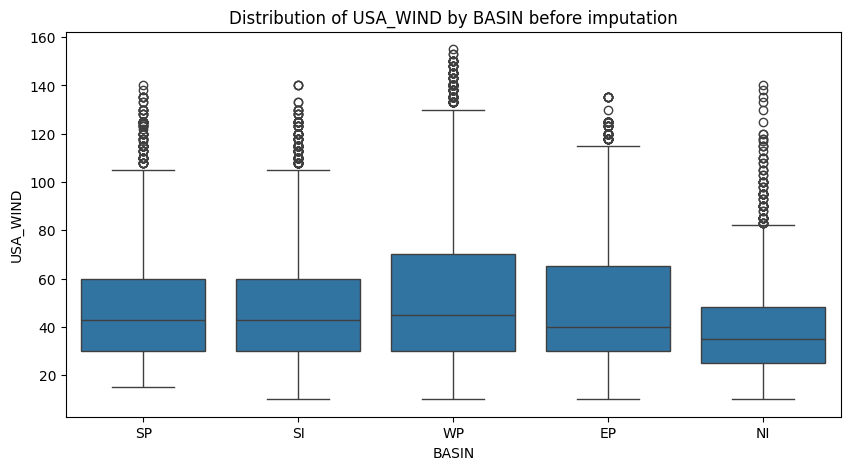

In [42]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["BASIN"], y=df["USA_WIND"])
plt.title("Distribution of USA_WIND by BASIN before imputation")
plt.show()

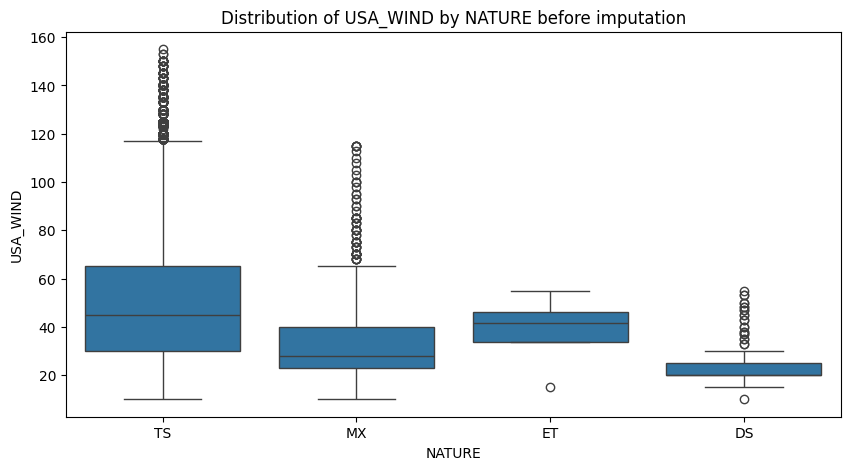

In [43]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["NATURE"], y=df["USA_WIND"])
plt.title("Distribution of USA_WIND by NATURE before imputation")
plt.show()

We notice that some combinations of basin and nature are NaN.For those cases, we use the median of the basin only

In [44]:
df.groupby(['BASIN'])['USA_WIND'].agg(['mean', 'median'])

,mean,median
BASIN,,
EP,49.577989,40.0
NI,40.013953,35.0
SI,48.242173,43.0
SP,47.879596,43.0
WP,52.917992,45.0


In [45]:
#we fill the nans with the median of the basin
df.loc[(df['BASIN'] == 'EP') & (df['NATURE'] == 'ET') & df['USA_WIND'].isna(), 'USA_WIND']=40
df.loc[(df['BASIN'] == 'SI') & (df['NATURE'] == 'ET') & df['USA_WIND'].isna(), 'USA_WIND']=43
df.loc[(df['BASIN'] == 'SI') & (df['NATURE'] == 'DS') & df['USA_WIND'].isna(), 'USA_WIND']=43

In [46]:
median_wind=df.groupby(["BASIN","NATURE"]).median().USA_WIND.to_dict()
median_wind

{('EP', 'DS'): 20.0,
 ('EP', 'ET'): 40.0,
 ('EP', 'MX'): 17.5,
 ('EP', 'TS'): 40.0,
 ('NI', 'DS'): 30.0,
 ('NI', 'MX'): 30.0,
 ('NI', 'TS'): 35.0,
 ('SI', 'DS'): 43.0,
 ('SI', 'ET'): 43.0,
 ('SI', 'MX'): 40.0,
 ('SI', 'TS'): 43.0,
 ('SP', 'MX'): 25.0,
 ('SP', 'TS'): 43.0,
 ('WP', 'DS'): 20.0,
 ('WP', 'ET'): 41.5,
 ('WP', 'MX'): 25.0,
 ('WP', 'TS'): 48.0}

In [47]:
def WIND_guesser(BASIN_NATURE):
    BASIN_NATURE = tuple(BASIN_NATURE)
    wind = median_wind[BASIN_NATURE]
    return wind

In [48]:
WIND_guesser(['WP','TS'])

48.0

In [49]:
df.loc[df.USA_WIND.isna(),"USA_WIND"] = df.loc[df.USA_WIND.isna(),["BASIN","NATURE"]].apply(WIND_guesser,axis=1)

In [50]:
df.isna().sum()

SEASON          0
BASIN           0
NATURE          0
LAT             0
LON             0
DIST2LAND       0
USA_WIND        0
TD9636_STAGE    0
STORM_SPEED     0
STORM_DIR       0
dtype: int64

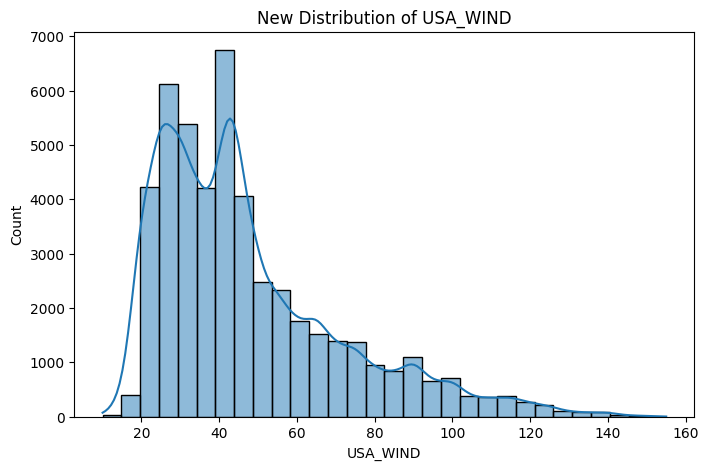

mean: 47.602930805608565 median: 43.0 variance: 24.368861372111162


In [51]:
#3. cheking the new distribution after transformation
plt.figure(figsize=(8, 5))
sns.histplot(df['USA_WIND'], bins=30, kde=True)
plt.title("New Distribution of USA_WIND")
plt.show()

print("mean:",df.USA_WIND.mean(),"median:", df.USA_WIND.median(),"variance:", df.USA_WIND.std())

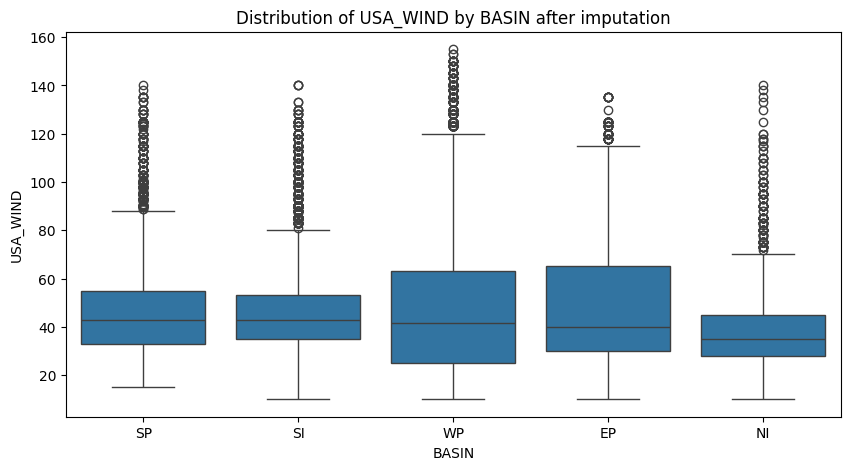

In [52]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["BASIN"], y=df["USA_WIND"])
plt.title("Distribution of USA_WIND by BASIN after imputation")
plt.show()


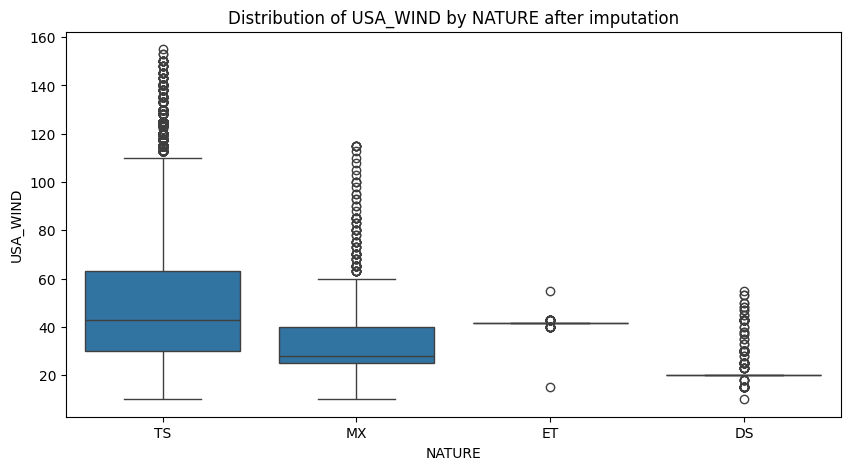

In [53]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["NATURE"], y=df["USA_WIND"])
plt.title("Distribution of USA_WIND by NATURE after imputation")
plt.show()


In [54]:
corr_apres = df["USA_WIND"].corr(df["TD9636_STAGE"])
print(f"Corrélation après imputation : {corr_apres:.4f}")

Corrélation après imputation : 0.7822


**Conclusion on Median Imputation:**

**Global Distribution `(USA_WIND)`**
- Before imputation: Unimodal distribution.
- After imputation: Artificial peaks appear at median values of categories (BASIN, NATURE).
Impact: Median imputation alters the natural data structure.

**Boxplots by `BASIN`**
- The median remains consistent, but imputation reduces variability in some categories.
The overall distribution appears similar but is artificially "smoothed."

**Boxplots by `NATURE`**
- Some categories (e.g., DS, ET) show a compression of values after imputation.
Variability reduction, which could impact the model.

**Global Statistics**
- Mean decreased (50.01 → 47.61)
- Variance reduced (25.49 → 24.38)
- Correlation with TD9636_STAGE decreased (0.84 → 0.78)
- Median remained stable (43.0 → 43.0)

➡️We choose to proceed with this imputation, accepting a slight reduction in variance and correlation.

➡️If the impact on model performance isn't negligible we can rework this part.

In [55]:
df.shape

(48212, 10)

We now have a dataframe with no missing values and with 48212rows x 10columns

In [56]:
#4.Encoding BASIN and NATURE
#We choose One-Hot Encoding with drop first because it avoids creating a false hierarchy between categories, 
#and with only 5 (BASIN) and 4 (NATURE) unique values, the added columns (7) remain manageable; 
#however, we can later switch to another encoding if needed.

df_encoded = pd.get_dummies(df, columns=['BASIN', 'NATURE'], drop_first=True)
df_encoded.head(3)


,SEASON,LAT,LON,DIST2LAND,USA_WIND,TD9636_STAGE,STORM_SPEED,STORM_DIR,BASIN_NI,BASIN_SI,BASIN_SP,BASIN_WP,NATURE_ET,NATURE_MX,NATURE_TS
0,1980,-12.5,172.5,647,25.0,1.0,6.0,350.0,False,False,True,False,False,False,True
1,1980,-12.2,172.4,653,25.0,1.0,6.0,350.0,False,False,True,False,False,False,True
2,1980,-11.9,172.4,670,25.0,1.0,5.0,360.0,False,False,True,False,False,False,True


OUR FINAL DATASET THAT WE WILL USE FOR THE MODEL TRAINING:

In [57]:
df_encoded.to_csv("train_test_dataset_TropicalStorms.csv",index=False)







<h1>Machine Learning Part</h1>

In [58]:
df=pd.read_csv('train_test_dataset_TropicalStorms.csv')

In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop(columns=["TD9636_STAGE"])  
y = df["TD9636_STAGE"] 

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.36, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.55, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_val_scaler = scaler.transform(X_val)
X_test_scaler = scaler.transform(X_test)

<h3>Logistic Regression</h3>

Rapport de classification :
               precision    recall  f1-score   support

         0.0       0.86      0.82      0.84       511
         1.0       0.76      0.71      0.73      2583
         2.0       0.71      0.61      0.65      2779
         3.0       0.15      0.83      0.25       120
         4.0       0.90      0.68      0.77      1721
         5.0       0.21      0.91      0.35        54
         6.0       0.08      0.69      0.15        42

    accuracy                           0.68      7810
   macro avg       0.52      0.75      0.54      7810
weighted avg       0.76      0.68      0.71      7810



c:\Users\paulv\OneDrive\Documents\Code IDIA\env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



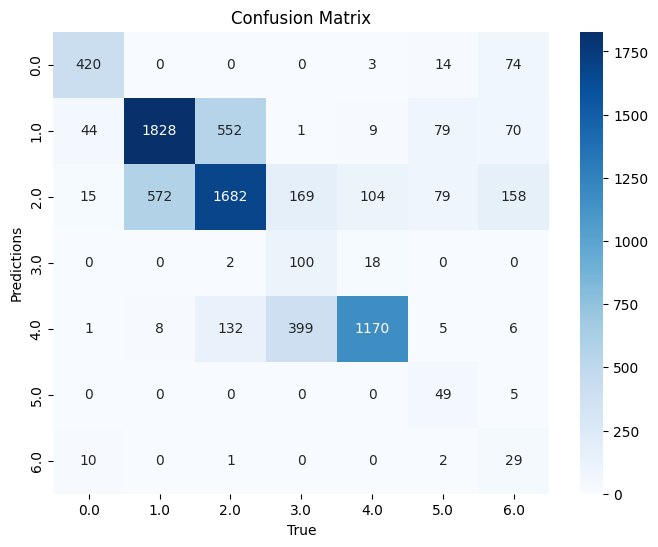

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr_model = LogisticRegression(class_weight="balanced", random_state=42)

lr_model.fit(X=X_train_scaler, y=y_train)
y_val_proba = lr_model.predict_proba(X_val_scaler)
y_val_predicted = np.argmax(y_val_proba, axis=1)

report_val_lr = classification_report(y_val, y_val_predicted, zero_division=0)
print("Rapport de classification :\n", report_val_lr)

conf_mat = confusion_matrix(y_val, y_val_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("True")
plt.ylabel("Predictions")
plt.title("Confusion Matrix")
plt.show()


<h3>Decision Tree</h3>

Rapport de classification :
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       511
         1.0       0.89      0.90      0.89      2583
         2.0       0.87      0.87      0.87      2779
         3.0       0.58      0.47      0.52       120
         4.0       0.90      0.92      0.91      1721
         5.0       0.86      0.80      0.83        54
         6.0       0.79      0.74      0.77        42

    accuracy                           0.89      7810
   macro avg       0.84      0.80      0.82      7810
weighted avg       0.88      0.89      0.88      7810



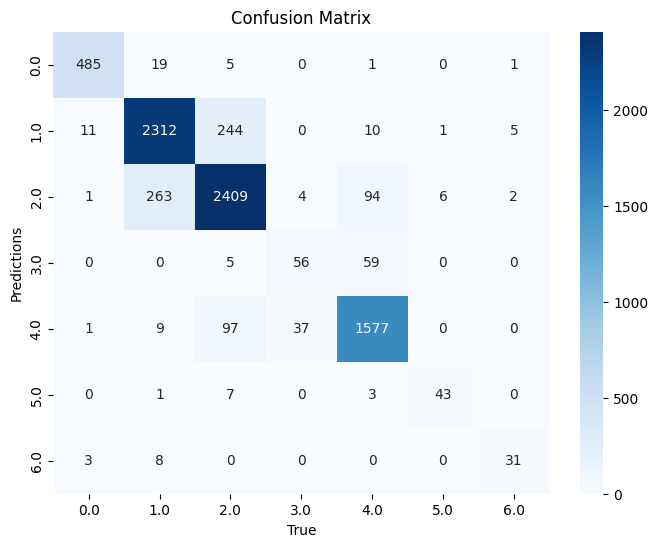

In [125]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

dt_model = DecisionTreeClassifier(class_weight="balanced", random_state=42)

dt_model.fit(X=X_train_scaler, y=y_train)
y_val_proba = dt_model.predict_proba(X_val_scaler)
y_val_predicted = np.argmax(y_val_proba, axis=1)

report_val_dt = classification_report(y_val, y_val_predicted, zero_division=0)
print("Rapport de classification :\n", report_val_dt)

conf_mat = confusion_matrix(y_val, y_val_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("True")
plt.ylabel("Predictions")
plt.title("Confusion Matrix")
plt.show()


<h3>MLPClassifier</h3>

Rapport de classification :
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.94       511
         1.0       0.86      0.85      0.85      2583
         2.0       0.82      0.84      0.83      2779
         3.0       0.54      0.32      0.40       120
         4.0       0.90      0.89      0.89      1721
         5.0       0.81      0.80      0.80        54
         6.0       0.62      0.19      0.29        42

    accuracy                           0.85      7810
   macro avg       0.78      0.70      0.72      7810
weighted avg       0.85      0.85      0.85      7810



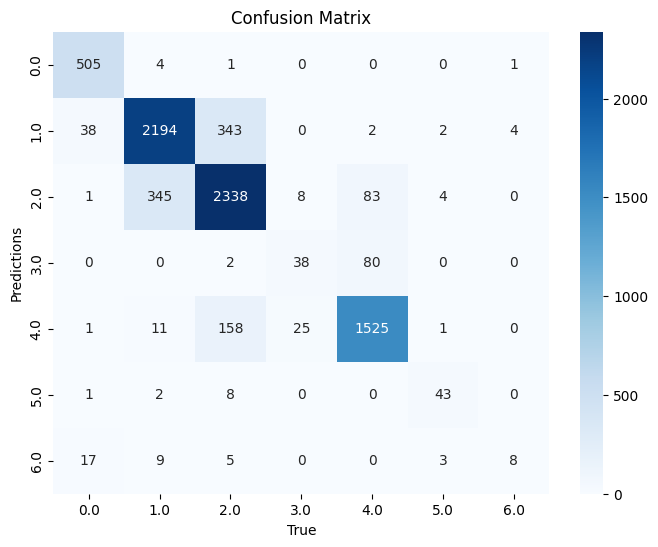

In [124]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

mlp_model = MLPClassifier(hidden_layer_sizes=(20,10),max_iter=1000,random_state=42)

mlp_model.fit(X=X_train_scaler, y=y_train)
y_val_proba = mlp_model.predict_proba(X_val_scaler)
y_val_predicted = np.argmax(y_val_proba, axis=1)

report_val_mlp = classification_report(y_val, y_val_predicted, zero_division=0)
print("Rapport de classification :\n", report_val_mlp)

conf_mat = confusion_matrix(y_val, y_val_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("True")
plt.ylabel("Predictions")
plt.title("Confusion Matrix")
plt.show()


<h3>RandomForest</h3>

Rapport de classification :
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       511
         1.0       0.95      0.93      0.94      2583
         2.0       0.91      0.94      0.92      2779
         3.0       0.78      0.47      0.59       120
         4.0       0.94      0.94      0.94      1721
         5.0       0.92      0.87      0.90        54
         6.0       0.96      0.64      0.77        42

    accuracy                           0.93      7810
   macro avg       0.92      0.83      0.86      7810
weighted avg       0.93      0.93      0.93      7810



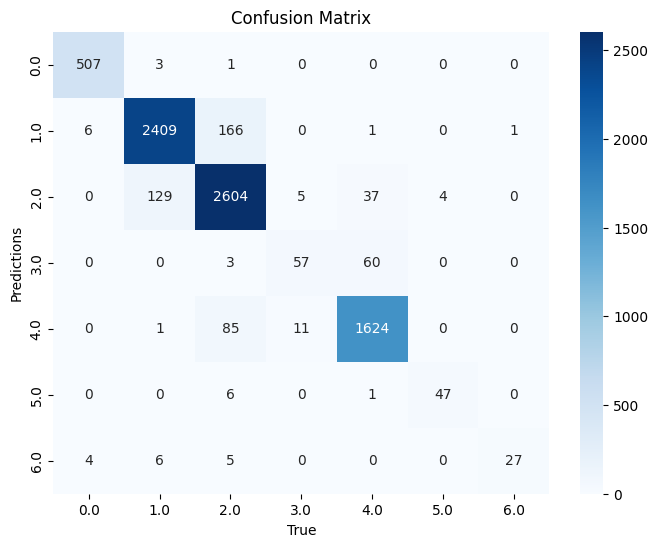

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf_model = RandomForestClassifier(class_weight="balanced",random_state=42)


rf_model.fit(X=X_train_scaler, y=y_train)
y_val_proba = rf_model.predict_proba(X_val_scaler)
y_val_predicted = np.argmax(y_val_proba, axis=1)

report_val_rf = classification_report(y_val, y_val_predicted, zero_division=0)
print("Rapport de classification :\n", report_val_rf)

conf_mat = confusion_matrix(y_val, y_val_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("True")
plt.ylabel("Predictions")
plt.title("Confusion Matrix")
plt.show()


In [131]:
y_train_proba = rf_model.predict_proba(X_train_scaler)
y_train_predicted = np.argmax(y_train_proba, axis=1)


report_train_rf = classification_report(y_train, y_train_predicted, zero_division=0)
print("TRAIN :\n", report_train_rf)

print("VALIDATION :\n", report_val_rf)


TRAIN :
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2018
         1.0       1.00      1.00      1.00     10206
         2.0       1.00      1.00      1.00     10980
         3.0       1.00      1.00      1.00       475
         4.0       1.00      1.00      1.00      6798
         5.0       1.00      1.00      1.00       212
         6.0       1.00      1.00      1.00       166

    accuracy                           1.00     30855
   macro avg       1.00      1.00      1.00     30855
weighted avg       1.00      1.00      1.00     30855

VALIDATION :
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       511
         1.0       0.95      0.93      0.94      2583
         2.0       0.91      0.94      0.92      2779
         3.0       0.78      0.47      0.59       120
         4.0       0.94      0.94      0.94      1721
         5.0       0.92      0.87      0.90        54
 

Report :
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.95       511
         1.0       0.89      0.81      0.85      2583
         2.0       0.79      0.86      0.83      2779
         3.0       0.34      0.87      0.49       120
         4.0       0.93      0.78      0.85      1721
         5.0       0.58      0.96      0.72        54
         6.0       0.52      0.79      0.63        42

    accuracy                           0.84      7810
   macro avg       0.71      0.87      0.76      7810
weighted avg       0.86      0.84      0.84      7810



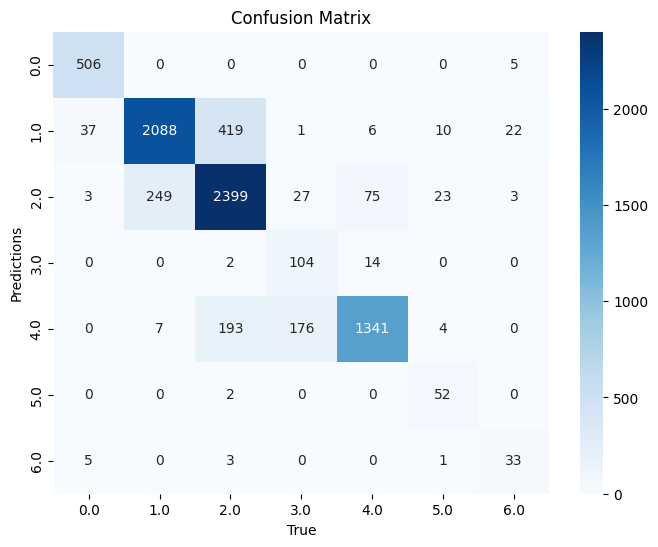

In [133]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,  
    min_samples_split=10,  
    min_samples_leaf=5,  
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train_scaler, y_train)

y_val_proba = rf_model.predict_proba(X_val_scaler)
y_val_predicted = np.argmax(y_val_proba, axis=1)

report_val_rf = classification_report(y_val, y_val_predicted, zero_division=0)
print("Report :\n", report_val_rf)

conf_mat = confusion_matrix(y_val, y_val_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("True")
plt.ylabel("Predictions")
plt.title("Confusion Matrix")
plt.show()

In [134]:

y_train_proba = rf_model.predict_proba(X_train_scaler)
y_train_predicted = np.argmax(y_train_proba, axis=1)

report_train_rf = classification_report(y_train, y_train_predicted, zero_division=0)
print("TRAIN :\n", report_train_rf)

print("VALIDATION :\n", report_val_rf)


TRAIN :
               precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      2018
         1.0       0.90      0.82      0.86     10206
         2.0       0.81      0.86      0.83     10980
         3.0       0.37      0.97      0.53       475
         4.0       0.94      0.79      0.86      6798
         5.0       0.62      1.00      0.77       212
         6.0       0.59      0.94      0.73       166

    accuracy                           0.84     30855
   macro avg       0.73      0.91      0.79     30855
weighted avg       0.86      0.84      0.85     30855

VALIDATION :
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.95       511
         1.0       0.89      0.81      0.85      2583
         2.0       0.79      0.86      0.83      2779
         3.0       0.34      0.87      0.49       120
         4.0       0.93      0.78      0.85      1721
         5.0       0.58      0.96      0.72        54
 

<h3>XGBoost</h3>

Report :
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       511
         1.0       0.90      0.90      0.90      2583
         2.0       0.86      0.88      0.87      2779
         3.0       0.65      0.43      0.52       120
         4.0       0.93      0.90      0.91      1721
         5.0       0.89      0.87      0.88        54
         6.0       0.91      0.71      0.80        42

    accuracy                           0.89      7810
   macro avg       0.87      0.81      0.84      7810
weighted avg       0.89      0.89      0.89      7810



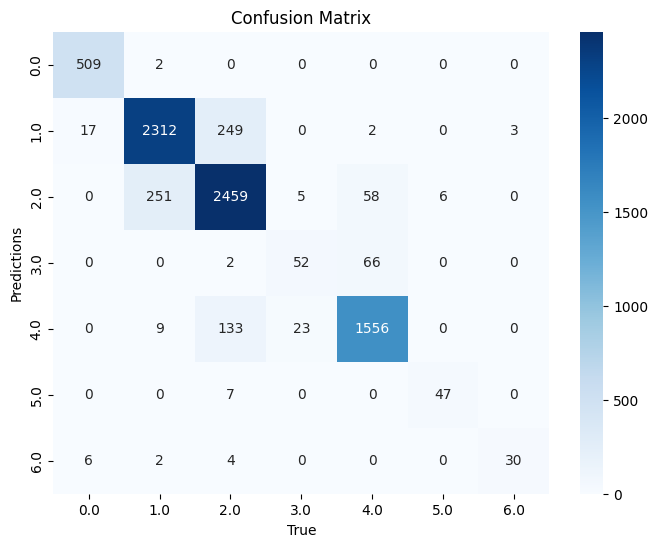

In [138]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_scaler, y_train)

y_val_proba = xgb_model.predict_proba(X_val_scaler)
y_val_predicted = np.argmax(y_val_proba, axis=1)

report_val_xgb = classification_report(y_val, y_val_predicted, zero_division=0)
print("Report :\n", report_val_xgb)

conf_mat = confusion_matrix(y_val, y_val_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("True")
plt.ylabel("Predictions")
plt.title("Confusion Matrix")
plt.show()

In [139]:
y_train_proba = xgb_model.predict_proba(X_train_scaler)
y_train_predicted = np.argmax(y_train_proba, axis=1)


report_train_xgb = classification_report(y_train, y_train_predicted, zero_division=0)
print("TRAIN :\n", report_train_xgb)

print("VALIDATION :\n", report_val_xgb)

TRAIN :
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      2018
         1.0       0.91      0.91      0.91     10206
         2.0       0.88      0.91      0.89     10980
         3.0       0.84      0.65      0.73       475
         4.0       0.95      0.93      0.94      6798
         5.0       0.97      0.98      0.98       212
         6.0       0.98      0.89      0.93       166

    accuracy                           0.91     30855
   macro avg       0.93      0.89      0.91     30855
weighted avg       0.91      0.91      0.91     30855

VALIDATION :
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       511
         1.0       0.90      0.90      0.90      2583
         2.0       0.86      0.88      0.87      2779
         3.0       0.65      0.43      0.52       120
         4.0       0.93      0.90      0.91      1721
         5.0       0.89      0.87      0.88        54
 

 We didn't noticed particular outliers to remove.
## We choose the Random Forest Model as our final Model to predict `TD9636_STAGE`

In [143]:
#Saving our model with pickle
import pickle

with open("model.pkl", "wb") as file:
    pickle.dump(xgb_model, file)
